In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import session_info
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import statsmodels.api as sm

In [2]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

In [3]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [4]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

# Get the processed data (V3)

In [5]:
arg_di_df_processed = pd.read_csv('../data/processed/WDICSV_PROCESSED_V3.csv').clean_names(case_type="snake")

print(arg_di_df_processed.shape)
arg_di_df_processed.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ny_gdp_mktp_kd_zg_cat   54 non-null     float64
 1   sp_dyn_le00_in_cat      54 non-null     float64
 2   ny_gdp_pcap_kd_cat      54 non-null     float64
 3   se_sec_enrr_cat         54 non-null     float64
 4   ny_gdp_mktp_kd_grw_cat  54 non-null     float64
 5   it_cel_sets_cat         54 non-null     float64
 6   year                    54 non-null     float64
 7   it_mlt_main             54 non-null     float64
 8   ny_gdp_mktp_kd_zg       54 non-null     float64
 9   ny_gdp_pcap_kd          54 non-null     float64
 10  ny_gdp_pcap_kd_zg       54 non-null     float64
 11  sp_dyn_le00_in          53 non-null     float64
 12  it_cel_sets             54 non-null     float64
 13  sh_dth_imrt             54 non-null     float64
 14  sp_pop_0014_to_zs       54 non-null

# Get columns names and types

In [6]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df, True)

NameError: name 'arg_di_df' is not defined

In [ ]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

numeric_cols = list(numeric_cols)

Total Columns: 28
Categorical Columns: 7
Numeric Columns: 21


In [27]:
arg_di_df_processed.dtypes

ny_gdp_mktp_kd_zg_cat     float64
sp_dyn_le00_in_cat        float64
ny_gdp_pcap_kd_cat        float64
se_sec_enrr_cat           float64
ny_gdp_mktp_kd_grw_cat    float64
it_cel_sets_cat           float64
year                      float64
it_mlt_main               float64
ny_gdp_mktp_kd_zg         float64
ny_gdp_pcap_kd            float64
ny_gdp_pcap_kd_zg         float64
sp_dyn_le00_in            float64
it_cel_sets               float64
sh_dth_imrt               float64
sp_pop_0014_to_zs         float64
sp_pop_1564_to_zs         float64
sp_pop_65_up_to_zs        float64
sp_pop_totl               float64
sm_pop_refg               float64
sm_pop_refg_or            float64
se_pre_enrr               float64
se_prm_enrr               float64
se_sec_enrr               float64
se_ter_enrr               float64
sp_urb_totl_in_zs         float64
year_of_dictatorship      float64
it_cel_sets_pct           float64
dem_dep_cat               float64
dtype: object

In [28]:
indicators_names

['ny_gdp_mktp_kd_zg_cat, GDP growth categories',
 'sp_dyn_le00_in_cat, Life Expectancy categories',
 'ny_gdp_pcap_kd_cat, GDP Per Capita Categories',
 'se_sec_enrr_cat, Secondary school enrollment categories',
 'ny_gdp_mktp_kd_grw_cat, GDP Growth Volatility',
 'it_cel_sets_cat, Mobile Subscription Categories',
 'year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 's

In [29]:
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Split target variable

Target variable: sp_dyn_le00_in (Life expectancy at birth, total (years))

In [30]:
target_variable = "sp_dyn_le00_in"
target_variable_name = get_indicator_name(target_variable, True)

In [31]:
if target_variable in numeric_cols:
    numeric_cols.remove(target_variable)
    
if 'year' in numeric_cols:
    numeric_cols.remove('year')

## Split rows with missing values in the target variable

In [13]:
rows_with_na = arg_di_df[arg_di_df[target_variable].isna()].copy()
rows_with_na

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,ny_gdp_pcap_kd_cat,se_sec_enrr_cat,ny_gdp_mktp_kd_grw_cat,it_cel_sets_cat,year,it_mlt_main,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,...,sm_pop_refg,sm_pop_refg_or,se_pre_enrr,se_prm_enrr,se_sec_enrr,se_ter_enrr,sp_urb_totl_in_zs,year_of_dictatorship,it_cel_sets_pct,dem_dep_cat
53,1.0,0.0,3.0,0.0,1.0,4.0,1.0,0.647369,0.432342,0.739951,...,0.041237,0.232682,NaN,NaN,NaN,NaN,1.0,0.0,0.841504,0.0


In [14]:
X = arg_di_df.drop(index=rows_with_na.index)[numeric_cols]
y = arg_di_df.drop(index=rows_with_na.index)[target_variable]

X.shape, y.shape

((53, 20), (53,))

# Apply Linear Regression

## Get predictions

In [17]:
def plot_residuals(y_test, y_pred):
    residuals = np.subtract(y_test, y_pred.reshape(-1))
    title = "Linear Regression Residuals"
    sns.scatterplot(x=y_pred, y=residuals)
    plt.title(title)
    plt.ylabel("")
    plt.show()
    
def apply_linear_regression(X, with_plot=True, print_shape=False, return_model=False):

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if print_shape:
        print('X_train shape: ', X_train.shape )
        print('X_test shape: ', X_test.shape )
        print('y_train shape: ', y_train.shape)
        print('y_test shape: ', y_test.shape)

    # Model training
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred.reshape(-1)
    X_test_sm = sm.add_constant(X_test)
    
    model_sm = sm.OLS(y_test, X_test_sm).fit()

    if return_model:
        return model_sm
    else:
        print('mse', round(metrics.mean_squared_error(y_test, y_pred),4))
        print(model_sm.summary())

    if with_plot:
        plot_residuals(y_test, y_pred)
        
    return None

# Evaluate the model

mse 0.0007
                            OLS Regression Results                            
Dep. Variable:         sp_dyn_le00_in   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 30 Jul 2025   Prob (F-statistic):                nan
Time:                        07:36:44   Log-Likelihood:                 361.50
No. Observations:                  11   AIC:                            -701.0
Df Residuals:                       0   BIC:                            -696.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.d

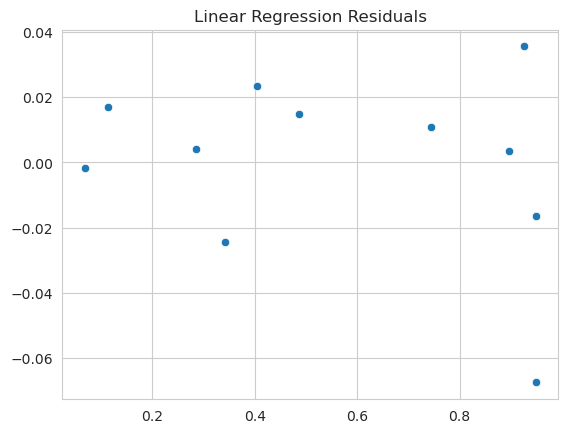

In [18]:
apply_linear_regression(X_mice)

This model is not useful due to the proportion between rows and columns

## Check correlation between variables to select less variables

<Axes: >

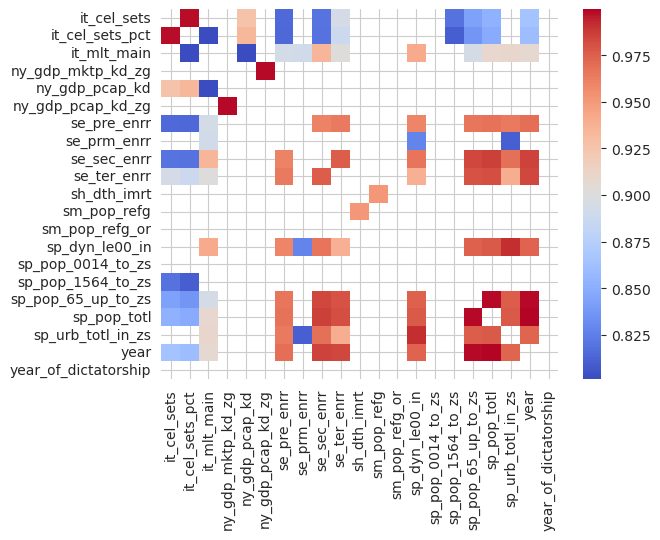

In [18]:
corr_matrix = arg_di_df_processed[sorted(numeric_cols)].corr()
high_corr_matrix = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
sns.heatmap(data=high_corr_matrix, cmap='coolwarm')

### Remove columns

<Axes: >

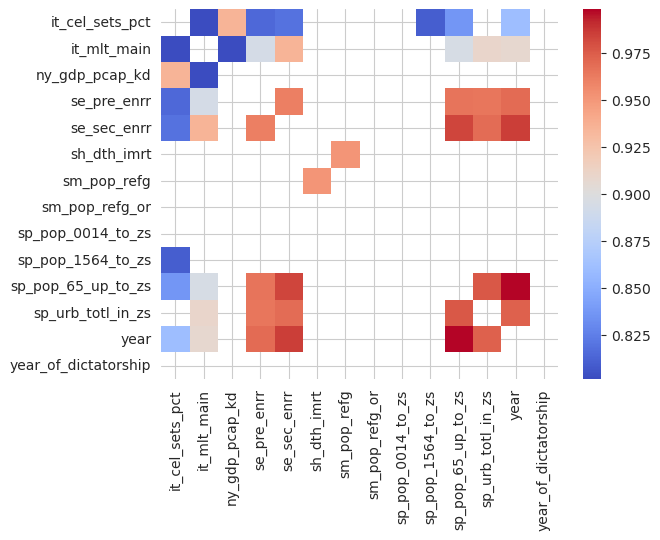

In [20]:
numeric_cols_2 = [col for col in numeric_cols if col not in ['it_cel_sets','sp_pop_totl','se_prm_enrr','se_ter_enrr','ny_gdp_pcap_kd_zg','ny_gdp_mktp_kd_zg']]

corr_matrix = arg_di_df[sorted(numeric_cols_2)].corr()
high_corr_matrix = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
sns.heatmap(data=high_corr_matrix, cmap='coolwarm')

mse 0.0004
                            OLS Regression Results                            
Dep. Variable:         sp_dyn_le00_in   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 30 Jul 2025   Prob (F-statistic):                nan
Time:                        07:36:45   Log-Likelihood:                 357.05
No. Observations:                  11   AIC:                            -692.1
Df Residuals:                       0   BIC:                            -687.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.d

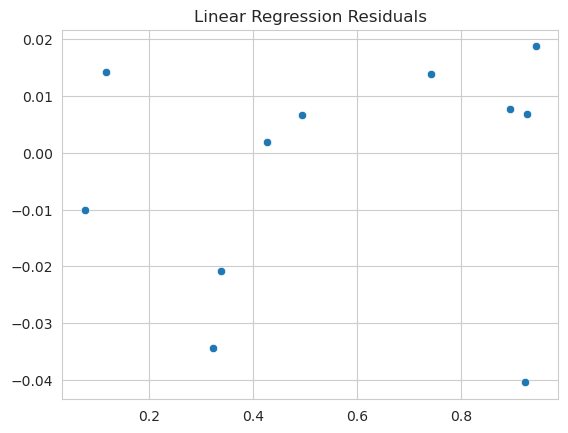

In [21]:
apply_linear_regression(X_mice[numeric_cols_2])

This model is not useful due to the proportion between rows and columns

### Selection of 3 variables for building the model

In [22]:
numeric_cols_2
variables_by_type_of_information = pd.DataFrame([
    # {'column_name': 'year', 'information_type': 'time'},
    # {'column_name': 'it_mlt_main', 'information_type': 'technology'},
    {'column_name': 'ny_gdp_pcap_kd', 'information_type': 'economy'},
    {'column_name': 'sh_dth_imrt', 'information_type': 'health'},
    # {'column_name': 'sp_pop_0014_to_zs', 'information_type': 'population'},
    # {'column_name': 'sp_pop_1564_to_zs', 'information_type': 'population'},
    {'column_name': 'sp_pop_65_up_to_zs', 'information_type': 'population'},
    # {'column_name': 'sm_pop_refg', 'information_type': 'population'},
    # {'column_name': 'sm_pop_refg_or', 'information_type': 'population'},
    {'column_name': 'se_pre_enrr', 'information_type': 'education'},
    # {'column_name': 'se_sec_enrr', 'information_type': 'education'},
    {'column_name': 'sp_urb_totl_in_zs', 'information_type': 'population'},
    {'column_name': 'year_of_dictatorship', 'information_type': 'politics'},
    {'column_name': 'it_cel_sets_pct', 'information_type': 'technology'}
])

information_types = variables_by_type_of_information['information_type'].unique()

import itertools
combinations = []

for combo in itertools.combinations(variables_by_type_of_information.itertuples(index=False), 3):
    types = {combo[0].information_type, combo[1].information_type, combo[2].information_type}
    if len(types) == 3:
        combinations.append([
            combo[0].column_name,
            combo[1].column_name,
            combo[2].column_name
        ])

In [23]:
models = []

for combination in combinations:
    models.append(apply_linear_regression(X_mice[combination], False, False, True))
   
combinations 
# print(len(models))

[['ny_gdp_pcap_kd', 'sh_dth_imrt', 'sp_pop_65_up_to_zs'],
 ['ny_gdp_pcap_kd', 'sh_dth_imrt', 'se_pre_enrr'],
 ['ny_gdp_pcap_kd', 'sh_dth_imrt', 'sp_urb_totl_in_zs'],
 ['ny_gdp_pcap_kd', 'sh_dth_imrt', 'year_of_dictatorship'],
 ['ny_gdp_pcap_kd', 'sh_dth_imrt', 'it_cel_sets_pct'],
 ['ny_gdp_pcap_kd', 'sp_pop_65_up_to_zs', 'se_pre_enrr'],
 ['ny_gdp_pcap_kd', 'sp_pop_65_up_to_zs', 'year_of_dictatorship'],
 ['ny_gdp_pcap_kd', 'sp_pop_65_up_to_zs', 'it_cel_sets_pct'],
 ['ny_gdp_pcap_kd', 'se_pre_enrr', 'sp_urb_totl_in_zs'],
 ['ny_gdp_pcap_kd', 'se_pre_enrr', 'year_of_dictatorship'],
 ['ny_gdp_pcap_kd', 'se_pre_enrr', 'it_cel_sets_pct'],
 ['ny_gdp_pcap_kd', 'sp_urb_totl_in_zs', 'year_of_dictatorship'],
 ['ny_gdp_pcap_kd', 'sp_urb_totl_in_zs', 'it_cel_sets_pct'],
 ['ny_gdp_pcap_kd', 'year_of_dictatorship', 'it_cel_sets_pct'],
 ['sh_dth_imrt', 'sp_pop_65_up_to_zs', 'se_pre_enrr'],
 ['sh_dth_imrt', 'sp_pop_65_up_to_zs', 'year_of_dictatorship'],
 ['sh_dth_imrt', 'sp_pop_65_up_to_zs', 'it_cel_set

In [39]:
def is_good_model(model, r2_threshold=0.7, f_pvalue_threshold=0.05, coef_pvalue_threshold=0.05):
    """
    Check if an OLS model meets the quality criteria.
    
    Parameters:
        model: A fitted statsmodels OLS object (e.g., sm.OLS(...).fit()).
        r2_threshold: Minimum R² or Adj. R² required.
        f_pvalue_threshold: Maximum acceptable p-value for F-statistic.
        coef_pvalue_threshold: Maximum acceptable p-value for individual predictors.
        
    Returns:
        bool: True if model is considered "good", otherwise False.
    """
    pvalues = model.pvalues.drop('const', errors='ignore')
    
    if (
        model.rsquared < r2_threshold and model.rsquared_adj < r2_threshold
        and model.f_pvalue > f_pvalue_threshold
        and any(p > coef_pvalue_threshold for p in pvalues)
    ):
        return True
    else:
        return False

In [40]:
good_models = []
for model in models:
    if is_good_model(model):
        good_models.append(model)
        
len(good_models)

0

## Apply PCA

arg_di_df_processed is already scaled

In [ ]:
#TODO: Summary interpretation
#TODO: Linear regression analysis

In [ ]:
pca = PCA()
pca.fit(X_mice)
arg_di_df_pca = pca.transform(X_mice)
arg_di_df_pca

NameError: name 'X_mice' is not defined